In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sun Feb 11 18:34:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 39%   68C    P2             254W / 450W |  21010MiB / 24564MiB |     79%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.bottleneck_swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2048
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = None
hp.N = 256
hp.z_activation = F.tanh

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 21.996826171875
encoder.convs 5.989013671875
encoder.linear 16.0078125
prior 0.0
latent 0.0
decoder 22.028697967529297
decoder.linear 16.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train02.11-8/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 136236
-rw-rw-r-- 1 scpark scpark    935345  2월 11 18:34 events.out.tfevents.1707643437.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 138563948  2월 11 18:24 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


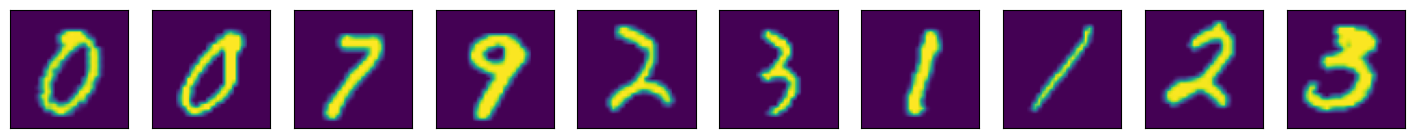

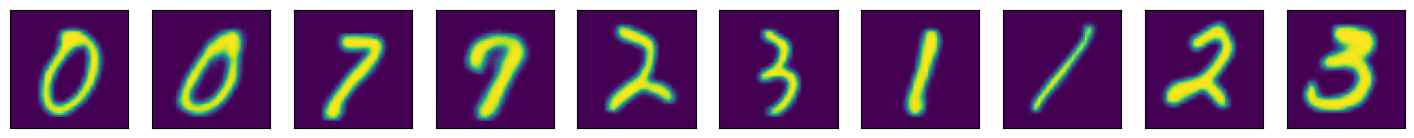

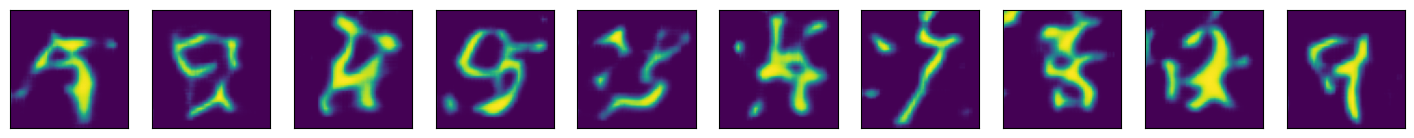

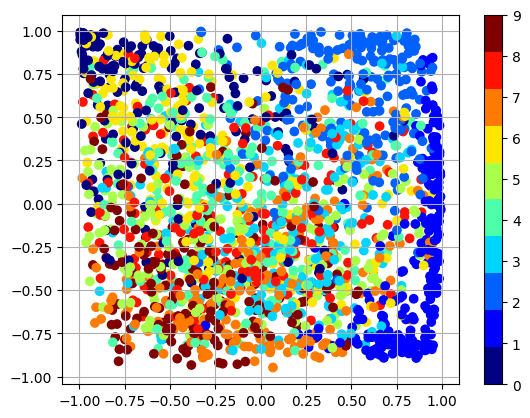

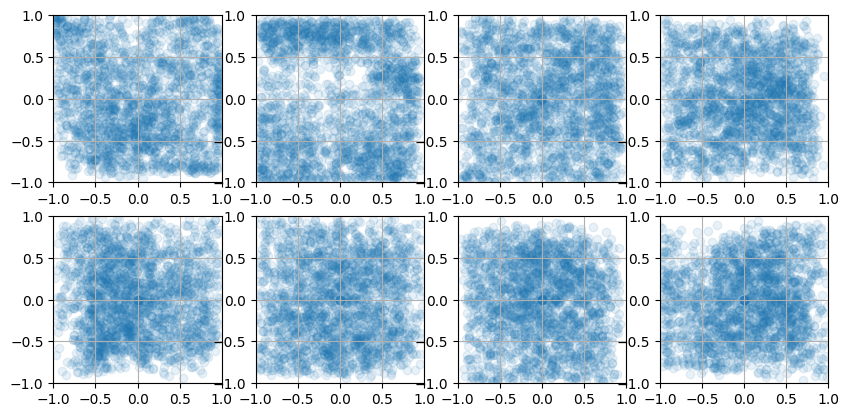

8001
swae_loss 0.016413910314440727
recon_loss 0.010697837918996811
8002
swae_loss 0.014453769661486149
recon_loss 0.013453148305416107
8003
swae_loss 0.015965724363923073
recon_loss 0.009959432296454906
8004
swae_loss 0.01642032340168953
recon_loss 0.01069178432226181
8005
swae_loss 0.014045423828065395
recon_loss 0.010112149640917778
8006
swae_loss 0.018913663923740387
recon_loss 0.011037412099540234
8007
swae_loss 0.015456478111445904
recon_loss 0.012100374326109886
8008
swae_loss 0.016559267416596413
recon_loss 0.009846294298768044
8009
swae_loss 0.013492653146386147
recon_loss 0.008946213871240616
8010
swae_loss 0.013460169546306133
recon_loss 0.01171082817018032
8011
swae_loss 0.014853090047836304
recon_loss 0.009324325248599052
8012
swae_loss 0.015673790127038956
recon_loss 0.010253685526549816
8013
swae_loss 0.016391277313232422
recon_loss 0.01030125841498375
8014
swae_loss 0.01491902582347393
recon_loss 0.00889395922422409
8015
swae_loss 0.013690485619008541
recon_loss 0.01099

8125
swae_loss 0.015497462823987007
recon_loss 0.01031397469341755
8126
swae_loss 0.013223407790064812
recon_loss 0.009759706445038319
8127
swae_loss 0.01424125861376524
recon_loss 0.009933620691299438
8128
swae_loss 0.015408012084662914
recon_loss 0.00948944129049778
8129
swae_loss 0.014811989851295948
recon_loss 0.010231388732790947
8130
swae_loss 0.01309354417026043
recon_loss 0.009704835712909698
8131
swae_loss 0.016217363998293877
recon_loss 0.009869348257780075
8132
swae_loss 0.012260236777365208
recon_loss 0.009084701538085938
8133
swae_loss 0.014253396540880203
recon_loss 0.008851764723658562
8134
swae_loss 0.016935816034674644
recon_loss 0.011315762996673584
8135
swae_loss 0.01512330025434494
recon_loss 0.01024792343378067
8136
swae_loss 0.015557226724922657
recon_loss 0.011180214583873749
8137
swae_loss 0.016715245321393013
recon_loss 0.00893198698759079
8138
swae_loss 0.01568010076880455
recon_loss 0.010148133151233196
8139
swae_loss 0.015157167799770832
recon_loss 0.0118754

swae_loss 0.014162315987050533
recon_loss 0.009496009908616543
8250
swae_loss 0.014591572806239128
recon_loss 0.008199814707040787
8251
swae_loss 0.017752058804035187
recon_loss 0.009498680010437965
8252
swae_loss 0.01692730002105236
recon_loss 0.00984385795891285
8253
swae_loss 0.0137143200263381
recon_loss 0.011274149641394615
8254
swae_loss 0.01305044163018465
recon_loss 0.008663156069815159
8255
swae_loss 0.014836959540843964
recon_loss 0.00911145843565464
8256
swae_loss 0.01391766406595707
recon_loss 0.009222224354743958
8257
swae_loss 0.012479566968977451
recon_loss 0.011227384209632874
8258
swae_loss 0.015607706271111965
recon_loss 0.009527493268251419
8259
swae_loss 0.01503454428166151
recon_loss 0.009006010368466377
8260
swae_loss 0.016632722690701485
recon_loss 0.008628846146166325
8261
swae_loss 0.014676516875624657
recon_loss 0.010003652423620224
8262
swae_loss 0.014748889952898026
recon_loss 0.012078952044248581
8263
swae_loss 0.018843170255422592
recon_loss 0.010126604698

8373
swae_loss 0.01733573153614998
recon_loss 0.012774030677974224
8374
swae_loss 0.01543484628200531
recon_loss 0.009806016460061073
8375
swae_loss 0.01493916381150484
recon_loss 0.00901767611503601
8376
swae_loss 0.016625141724944115
recon_loss 0.00962497852742672
8377
swae_loss 0.013677959330379963
recon_loss 0.011134221218526363
8378
swae_loss 0.013969984836876392
recon_loss 0.008788758888840675
8379
swae_loss 0.01588522084057331
recon_loss 0.009978609159588814
8380
swae_loss 0.013597137294709682
recon_loss 0.008964212611317635
8381
swae_loss 0.016372088342905045
recon_loss 0.009177271276712418
8382
swae_loss 0.01476376410573721
recon_loss 0.009415870532393456
8383
swae_loss 0.014302877709269524
recon_loss 0.011761556379497051
8384
swae_loss 0.012370187789201736
recon_loss 0.009230973199009895
8385
swae_loss 0.016690442338585854
recon_loss 0.010199123062193394
8386
swae_loss 0.013320590369403362
recon_loss 0.009530937299132347
8387
swae_loss 0.014114663004875183
recon_loss 0.009062

8497
swae_loss 0.012343215756118298
recon_loss 0.009882140904664993
8498
swae_loss 0.015709800645709038
recon_loss 0.008801639080047607
8499
swae_loss 0.01448929775506258
recon_loss 0.00877800676971674
8500
swae_loss 0.013802051544189453
recon_loss 0.008673486299812794
8501
swae_loss 0.01786639168858528
recon_loss 0.009335247799754143
8502
swae_loss 0.012806701473891735
recon_loss 0.008975203149020672
8503
swae_loss 0.014887389726936817
recon_loss 0.012350507080554962
8504
swae_loss 0.014271749183535576
recon_loss 0.009419605135917664
8505
swae_loss 0.015432261861860752
recon_loss 0.010663468390703201
8506
swae_loss 0.014691269025206566
recon_loss 0.009673010557889938
8507
swae_loss 0.018526112660765648
recon_loss 0.009927915409207344
8508
swae_loss 0.015774866566061974
recon_loss 0.009132553823292255
8509
swae_loss 0.016741078346967697
recon_loss 0.008538870140910149
8510
swae_loss 0.012761439196765423
recon_loss 0.008942493237555027
8511
swae_loss 0.015105064027011395
recon_loss 0.00

8619
swae_loss 0.014827494509518147
recon_loss 0.010057506151497364
8620
swae_loss 0.016082817688584328
recon_loss 0.009611204266548157
8621
swae_loss 0.01287318579852581
recon_loss 0.009938789531588554
8622
swae_loss 0.01425448153167963
recon_loss 0.011237844824790955
8623
swae_loss 0.015101506374776363
recon_loss 0.009111053310334682
8624
swae_loss 0.015716295689344406
recon_loss 0.011600512079894543
8625
swae_loss 0.013927018269896507
recon_loss 0.009258374571800232
8626
swae_loss 0.017935607582330704
recon_loss 0.008820842020213604
8627
swae_loss 0.016036633402109146
recon_loss 0.010313457809388638
8628
swae_loss 0.013330787420272827
recon_loss 0.009897498413920403
8629
swae_loss 0.015441130846738815
recon_loss 0.009703148156404495
8630
swae_loss 0.014234506525099277
recon_loss 0.011242805048823357
8631
swae_loss 0.015428174287080765
recon_loss 0.011192478239536285
8632
swae_loss 0.013237997889518738
recon_loss 0.009642988443374634
8633
swae_loss 0.01326457504183054
recon_loss 0.01

swae_loss 0.015465766191482544
recon_loss 0.008770937100052834
8743
swae_loss 0.01375581230968237
recon_loss 0.009428756311535835
8744
swae_loss 0.013707124628126621
recon_loss 0.008291499689221382
8745
swae_loss 0.017970742657780647
recon_loss 0.009975213557481766
8746
swae_loss 0.01644662581384182
recon_loss 0.009645748883485794
8747
swae_loss 0.014400344341993332
recon_loss 0.010700303129851818
8748
swae_loss 0.017107725143432617
recon_loss 0.011218319647014141
8749
swae_loss 0.014283968135714531
recon_loss 0.00953018106520176
8750
swae_loss 0.013103323057293892
recon_loss 0.009748133830726147
8751
swae_loss 0.015888744965195656
recon_loss 0.008693619631230831
8752
swae_loss 0.014342207461595535
recon_loss 0.009772825054824352
8753
swae_loss 0.013080907985568047
recon_loss 0.009767738170921803
8754
swae_loss 0.012197794392704964
recon_loss 0.0100420992821455
8755
swae_loss 0.01637125015258789
recon_loss 0.009714081883430481
8756
swae_loss 0.014920389279723167
recon_loss 0.0101552596

8866
swae_loss 0.01433887891471386
recon_loss 0.008147120475769043
8867
swae_loss 0.014624270610511303
recon_loss 0.00887338537722826
8868
swae_loss 0.014893719926476479
recon_loss 0.009602516889572144
8869
swae_loss 0.014384789392352104
recon_loss 0.01038605347275734
8870
swae_loss 0.0160546712577343
recon_loss 0.009782823733985424
8871
swae_loss 0.013534163124859333
recon_loss 0.00917859748005867
8872
swae_loss 0.01603127084672451
recon_loss 0.009724041447043419
8873
swae_loss 0.012603824026882648
recon_loss 0.008509359322488308
8874
swae_loss 0.013287444598972797
recon_loss 0.01078716292977333
8875
swae_loss 0.017998196184635162
recon_loss 0.009746959432959557
8876
swae_loss 0.013952584005892277
recon_loss 0.010034496895968914
8877
swae_loss 0.013820795342326164
recon_loss 0.009896195493638515
8878
swae_loss 0.013678735122084618
recon_loss 0.010295379906892776
8879
swae_loss 0.014662973582744598
recon_loss 0.01072621624916792
8880
swae_loss 0.014016459695994854
recon_loss 0.00811953

KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'wise_min_loss' in key:
                    loss = loss + data[key] * 1e+4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
            
            _z = data['z'].data.cpu().numpy()

            plt.figure(figsize=[10, 10])
            for i in range(8):
                plt.subplot(4, 4, i+1)
                plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
                plt.grid()
                plt.xlim([-1, 1])
                plt.ylim([-1, 1])

            plt.show()
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
plt.figure(figsize=[10, 10])
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
    plt.grid()
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    
plt.show()